<a href="https://colab.research.google.com/github/kenpurin/Retrosynthesis_TF/blob/main/Transformer_Retrosynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANGUAGE TRANSLATION WITH TRANSFORMER

In [1]:
!nvidia-smi

Sat May 22 20:39:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#load data and insatall

In [2]:
!git clone https://github.com/kenpurin/Retrosynthesis_TF.git

Cloning into 'Retrosynthesis_TF'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 94 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [3]:
!pip3 install rich
!pip3 show torch

     |████████████████████████████████| 204kB 2.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
Name: torch
Version: 1.8.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions, numpy
Required-by: torchvision, torchtext, fastai


# Data Processing

In [4]:
import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor
import io
import time
from rich import print
import matplotlib.pyplot as plt


In [5]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
!nvcc --version

1.8.1+cu101

True

Tesla P100-PCIE-16GB

Memory Usage:

Allocated: 0.0 GB

Cached:    0.0 GB

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [6]:
#load data USPTO-50K
train_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-train.txt'
train_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-train.txt'
val_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-val.txt'
val_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-val.txt'
test_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-test.txt'
test_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-test.txt'

In [7]:
#build_vocab
src_filepath='Retrosynthesis_TF/USPTO-50K/src/src.txt'
tgt_filepath='Retrosynthesis_TF/USPTO-50K/tgt/tgt.txt'

In [8]:
#https://pytorch.org/text/stable/data_utils.html use toktok or spacy
tokenizer = get_tokenizer('toktok')

In [9]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
src_vocab = build_vocab(src_filepath,tokenizer)
tgt_vocab = build_vocab(tgt_filepath,tokenizer)

In [10]:
def data_process(filepaths1,filepaths2):
  raw_src_iter = iter(io.open(filepaths1, encoding="utf8"))
  raw_tgt_iter = iter(io.open(filepaths2, encoding="utf8"))
  data = []
  for (raw_src, raw_tgt) in zip(raw_src_iter, raw_tgt_iter):
    src_tensor_ = torch.tensor([src_vocab[token] for token in tokenizer(raw_src.rstrip("\n"))],
                            dtype=torch.long)
    tgt_tensor_ = torch.tensor([tgt_vocab[token] for token in tokenizer(raw_tgt.rstrip("\n"))],
                            dtype=torch.long)
    data.append((src_tensor_, tgt_tensor_))
  return data

In [11]:
train_data = data_process(train_src_filepaths,train_tgt_filepaths)
val_data = data_process(val_src_filepaths,val_tgt_filepaths)
test_data = data_process(test_src_filepaths,test_tgt_filepaths)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128
PAD_IDX = src_vocab['<pad>']
BOS_IDX = src_vocab['<bos>']
EOS_IDX = src_vocab['<eos>']

# DataLoader

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  src_batch, tgt_batch = [], []
  for (src_item, tgt_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
    tgt_batch.append(torch.cat([torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0))
  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

#Transformer

In [14]:
#https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        #TransformerEncoderLayer is made up of self-attn and feedforward network.
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerEncoder is a stack of N encoder layers
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        #	TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network.
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerDecoder is a stack of N decoder layers
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [16]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [17]:
# Training hyperparameters
SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 500

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
#model 
transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

In [18]:
#show model
print(transformer)

Seq2SeqTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (2): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, inplace=False)
      )
      (2): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj

#Save checkpoint

In [19]:
load_model = True
save_model = True

In [20]:
def save_checkpoint(state, filename):
    #filename="my_checkpoint_"+str(epoch)+".pth"
    print("=> Saving checkpoint")
    torch.save(state, filename)

#Load checkpoint

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
if load_model:
    load_checkpoint(torch.load("my_checkpoint_10.pth"), transformer, optimizer)



=> Loading checkpoint

# Train model

In [21]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(train_iter):
      src = src.to(device)
      tgt = tgt.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, (src, tgt) in (enumerate(valid_iter)):
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)

In [22]:
train_loss_ex = []
val_loss_ex = []
epoch_ex=[]
for epoch in range(1, NUM_EPOCHS+1):
  start_time = time.time()
  train_loss = train_epoch(transformer, train_iter, optimizer)
  end_time = time.time()
  val_loss = evaluate(transformer, valid_iter)
  #Save the general checkpoint
  if epoch%100==0:
    filename="my_checkpoint_"+str(epoch)+".pth"
    print("true")
    checkpoint = {"state_dict": transformer.state_dict(),"optimizer": optimizer.state_dict(),}
    save_checkpoint(checkpoint,filename)

  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
  #plot
  train_loss_ex.append(train_loss)
  epoch_ex.append(epoch)
  val_loss_ex.append(val_loss)
  
print("Done!")

Epoch: 1, Train loss: 1.533, Val loss: 1.026, Epoch time = 92.444s

Epoch: 2, Train loss: 1.006, Val loss: 0.809, Epoch time = 91.709s

Epoch: 3, Train loss: 0.853, Val loss: 0.704, Epoch time = 91.513s

Epoch: 4, Train loss: 0.765, Val loss: 0.636, Epoch time = 91.669s

Epoch: 5, Train loss: 0.704, Val loss: 0.580, Epoch time = 91.423s

Epoch: 6, Train loss: 0.658, Val loss: 0.555, Epoch time = 91.776s

Epoch: 7, Train loss: 0.619, Val loss: 0.511, Epoch time = 91.666s

Epoch: 8, Train loss: 0.585, Val loss: 0.486, Epoch time = 92.433s

Epoch: 9, Train loss: 0.555, Val loss: 0.448, Epoch time = 91.984s

Epoch: 10, Train loss: 0.525, Val loss: 0.424, Epoch time = 91.401s

Epoch: 11, Train loss: 0.499, Val loss: 0.397, Epoch time = 91.825s

Epoch: 12, Train loss: 0.473, Val loss: 0.382, Epoch time = 92.055s

Epoch: 13, Train loss: 0.450, Val loss: 0.355, Epoch time = 92.521s

Epoch: 14, Train loss: 0.426, Val loss: 0.327, Epoch time = 91.871s

Epoch: 15, Train loss: 0.404, Val loss: 0.306, Epoch time = 91.417s

Epoch: 16, Train loss: 0.385, Val loss: 0.293, Epoch time = 91.943s

Epoch: 17, Train loss: 0.366, Val loss: 0.282, Epoch time = 91.411s

Epoch: 18, Train loss: 0.350, Val loss: 0.264, Epoch time = 91.731s

Epoch: 19, Train loss: 0.334, Val loss: 0.255, Epoch time = 92.045s

Epoch: 20, Train loss: 0.319, Val loss: 0.245, Epoch time = 92.433s

Epoch: 21, Train loss: 0.305, Val loss: 0.229, Epoch time = 91.646s

Epoch: 22, Train loss: 0.292, Val loss: 0.224, Epoch time = 92.517s

Epoch: 23, Train loss: 0.280, Val loss: 0.207, Epoch time = 91.476s

Epoch: 24, Train loss: 0.267, Val loss: 0.198, Epoch time = 91.605s

Epoch: 25, Train loss: 0.257, Val loss: 0.197, Epoch time = 91.464s

Epoch: 26, Train loss: 0.247, Val loss: 0.187, Epoch time = 92.069s

Epoch: 27, Train loss: 0.237, Val loss: 0.179, Epoch time = 92.320s

Epoch: 28, Train loss: 0.229, Val loss: 0.173, Epoch time = 91.745s

Epoch: 29, Train loss: 0.219, Val loss: 0.166, Epoch time = 91.596s

Epoch: 30, Train loss: 0.212, Val loss: 0.164, Epoch time = 91.945s

Epoch: 31, Train loss: 0.204, Val loss: 0.155, Epoch time = 91.797s

Epoch: 32, Train loss: 0.197, Val loss: 0.153, Epoch time = 91.979s

Epoch: 33, Train loss: 0.191, Val loss: 0.147, Epoch time = 92.030s

Epoch: 34, Train loss: 0.185, Val loss: 0.143, Epoch time = 91.730s

Epoch: 35, Train loss: 0.178, Val loss: 0.142, Epoch time = 92.135s

Epoch: 36, Train loss: 0.174, Val loss: 0.140, Epoch time = 92.070s

Epoch: 37, Train loss: 0.168, Val loss: 0.137, Epoch time = 92.265s

Epoch: 38, Train loss: 0.163, Val loss: 0.134, Epoch time = 92.761s

Epoch: 39, Train loss: 0.159, Val loss: 0.128, Epoch time = 92.655s

Epoch: 40, Train loss: 0.155, Val loss: 0.127, Epoch time = 92.001s

Epoch: 41, Train loss: 0.151, Val loss: 0.126, Epoch time = 91.732s

Epoch: 42, Train loss: 0.147, Val loss: 0.125, Epoch time = 92.876s

Epoch: 43, Train loss: 0.143, Val loss: 0.121, Epoch time = 91.848s

Epoch: 44, Train loss: 0.140, Val loss: 0.121, Epoch time = 92.038s

Epoch: 45, Train loss: 0.136, Val loss: 0.121, Epoch time = 91.551s

Epoch: 46, Train loss: 0.133, Val loss: 0.120, Epoch time = 92.120s

Epoch: 47, Train loss: 0.130, Val loss: 0.117, Epoch time = 91.639s

Epoch: 48, Train loss: 0.127, Val loss: 0.114, Epoch time = 92.147s

Epoch: 49, Train loss: 0.124, Val loss: 0.114, Epoch time = 92.281s

Epoch: 50, Train loss: 0.121, Val loss: 0.114, Epoch time = 91.869s

Epoch: 51, Train loss: 0.119, Val loss: 0.112, Epoch time = 91.352s

Epoch: 52, Train loss: 0.116, Val loss: 0.108, Epoch time = 91.958s

Epoch: 53, Train loss: 0.114, Val loss: 0.107, Epoch time = 92.089s

Epoch: 54, Train loss: 0.111, Val loss: 0.109, Epoch time = 92.431s

Epoch: 55, Train loss: 0.110, Val loss: 0.107, Epoch time = 92.083s

Epoch: 56, Train loss: 0.107, Val loss: 0.105, Epoch time = 91.788s

Epoch: 57, Train loss: 0.105, Val loss: 0.108, Epoch time = 92.099s

Epoch: 58, Train loss: 0.103, Val loss: 0.105, Epoch time = 91.936s

Epoch: 59, Train loss: 0.101, Val loss: 0.109, Epoch time = 91.591s

Epoch: 60, Train loss: 0.099, Val loss: 0.106, Epoch time = 92.158s

Epoch: 61, Train loss: 0.097, Val loss: 0.106, Epoch time = 92.195s

Epoch: 62, Train loss: 0.096, Val loss: 0.104, Epoch time = 91.404s

Epoch: 63, Train loss: 0.094, Val loss: 0.102, Epoch time = 92.321s

Epoch: 64, Train loss: 0.092, Val loss: 0.103, Epoch time = 92.415s

Epoch: 65, Train loss: 0.091, Val loss: 0.105, Epoch time = 91.520s

Epoch: 66, Train loss: 0.089, Val loss: 0.100, Epoch time = 91.682s

Epoch: 67, Train loss: 0.088, Val loss: 0.102, Epoch time = 92.310s

Epoch: 68, Train loss: 0.086, Val loss: 0.106, Epoch time = 92.347s

Epoch: 69, Train loss: 0.085, Val loss: 0.100, Epoch time = 91.824s

Epoch: 70, Train loss: 0.084, Val loss: 0.100, Epoch time = 92.070s

Epoch: 71, Train loss: 0.082, Val loss: 0.102, Epoch time = 91.722s

Epoch: 72, Train loss: 0.081, Val loss: 0.100, Epoch time = 92.089s

Epoch: 73, Train loss: 0.080, Val loss: 0.101, Epoch time = 91.901s

Epoch: 74, Train loss: 0.078, Val loss: 0.100, Epoch time = 92.053s

Epoch: 75, Train loss: 0.077, Val loss: 0.102, Epoch time = 91.799s

Epoch: 76, Train loss: 0.076, Val loss: 0.099, Epoch time = 91.806s

Epoch: 77, Train loss: 0.075, Val loss: 0.102, Epoch time = 92.169s

Epoch: 78, Train loss: 0.073, Val loss: 0.100, Epoch time = 92.114s

Epoch: 79, Train loss: 0.073, Val loss: 0.100, Epoch time = 92.396s

Epoch: 80, Train loss: 0.072, Val loss: 0.098, Epoch time = 91.451s

Epoch: 81, Train loss: 0.070, Val loss: 0.101, Epoch time = 91.980s

Epoch: 82, Train loss: 0.069, Val loss: 0.099, Epoch time = 92.182s

Epoch: 83, Train loss: 0.069, Val loss: 0.100, Epoch time = 91.760s

Epoch: 84, Train loss: 0.068, Val loss: 0.101, Epoch time = 91.489s

Epoch: 85, Train loss: 0.066, Val loss: 0.099, Epoch time = 92.157s

Epoch: 86, Train loss: 0.066, Val loss: 0.101, Epoch time = 91.749s

Epoch: 87, Train loss: 0.065, Val loss: 0.099, Epoch time = 92.333s

Epoch: 88, Train loss: 0.064, Val loss: 0.099, Epoch time = 92.015s

Epoch: 89, Train loss: 0.063, Val loss: 0.099, Epoch time = 92.481s

Epoch: 90, Train loss: 0.062, Val loss: 0.098, Epoch time = 92.239s

Epoch: 91, Train loss: 0.062, Val loss: 0.099, Epoch time = 91.701s

Epoch: 92, Train loss: 0.061, Val loss: 0.098, Epoch time = 92.036s

Epoch: 93, Train loss: 0.060, Val loss: 0.100, Epoch time = 91.929s

Epoch: 94, Train loss: 0.059, Val loss: 0.101, Epoch time = 92.234s

Epoch: 95, Train loss: 0.058, Val loss: 0.100, Epoch time = 92.066s

Epoch: 96, Train loss: 0.058, Val loss: 0.102, Epoch time = 92.591s

Epoch: 97, Train loss: 0.057, Val loss: 0.102, Epoch time = 91.415s

Epoch: 98, Train loss: 0.056, Val loss: 0.099, Epoch time = 91.789s

Epoch: 99, Train loss: 0.056, Val loss: 0.100, Epoch time = 91.747s

true

=> Saving checkpoint

Epoch: 100, Train loss: 0.054, Val loss: 0.104, Epoch time = 92.133s

Epoch: 101, Train loss: 0.054, Val loss: 0.099, Epoch time = 91.761s

Epoch: 102, Train loss: 0.053, Val loss: 0.102, Epoch time = 91.207s

Epoch: 103, Train loss: 0.053, Val loss: 0.099, Epoch time = 91.967s

Epoch: 104, Train loss: 0.053, Val loss: 0.101, Epoch time = 91.458s

Epoch: 105, Train loss: 0.052, Val loss: 0.101, Epoch time = 91.519s

Epoch: 106, Train loss: 0.051, Val loss: 0.103, Epoch time = 92.493s

Epoch: 107, Train loss: 0.050, Val loss: 0.103, Epoch time = 91.877s

Epoch: 108, Train loss: 0.050, Val loss: 0.100, Epoch time = 91.630s

Epoch: 109, Train loss: 0.049, Val loss: 0.102, Epoch time = 91.458s

Epoch: 110, Train loss: 0.049, Val loss: 0.104, Epoch time = 91.612s

Epoch: 111, Train loss: 0.048, Val loss: 0.103, Epoch time = 91.771s

Epoch: 112, Train loss: 0.048, Val loss: 0.103, Epoch time = 92.705s

Epoch: 113, Train loss: 0.047, Val loss: 0.102, Epoch time = 91.949s

Epoch: 114, Train loss: 0.046, Val loss: 0.106, Epoch time = 92.187s

Epoch: 115, Train loss: 0.046, Val loss: 0.102, Epoch time = 92.203s

Epoch: 116, Train loss: 0.046, Val loss: 0.103, Epoch time = 92.538s

Epoch: 117, Train loss: 0.045, Val loss: 0.104, Epoch time = 91.700s

Epoch: 118, Train loss: 0.045, Val loss: 0.103, Epoch time = 92.032s

Epoch: 119, Train loss: 0.044, Val loss: 0.103, Epoch time = 91.600s

Epoch: 120, Train loss: 0.044, Val loss: 0.104, Epoch time = 91.746s

Epoch: 121, Train loss: 0.043, Val loss: 0.103, Epoch time = 92.046s

Epoch: 122, Train loss: 0.043, Val loss: 0.103, Epoch time = 92.529s

Epoch: 123, Train loss: 0.042, Val loss: 0.105, Epoch time = 91.770s

Epoch: 124, Train loss: 0.042, Val loss: 0.106, Epoch time = 92.225s

Epoch: 125, Train loss: 0.041, Val loss: 0.106, Epoch time = 91.490s

Epoch: 126, Train loss: 0.041, Val loss: 0.107, Epoch time = 92.095s

Epoch: 127, Train loss: 0.041, Val loss: 0.107, Epoch time = 91.480s

Epoch: 128, Train loss: 0.040, Val loss: 0.107, Epoch time = 91.800s

Epoch: 129, Train loss: 0.040, Val loss: 0.108, Epoch time = 91.849s

Epoch: 130, Train loss: 0.040, Val loss: 0.107, Epoch time = 91.170s

Epoch: 131, Train loss: 0.039, Val loss: 0.107, Epoch time = 91.664s

Epoch: 132, Train loss: 0.038, Val loss: 0.107, Epoch time = 91.384s

Epoch: 133, Train loss: 0.038, Val loss: 0.106, Epoch time = 92.238s

Epoch: 134, Train loss: 0.038, Val loss: 0.109, Epoch time = 91.283s

Epoch: 135, Train loss: 0.038, Val loss: 0.109, Epoch time = 91.547s

Epoch: 136, Train loss: 0.037, Val loss: 0.107, Epoch time = 92.143s

Epoch: 137, Train loss: 0.037, Val loss: 0.111, Epoch time = 92.342s

Epoch: 138, Train loss: 0.037, Val loss: 0.115, Epoch time = 91.953s

Epoch: 139, Train loss: 0.036, Val loss: 0.111, Epoch time = 91.745s

Epoch: 140, Train loss: 0.036, Val loss: 0.115, Epoch time = 91.830s

Epoch: 141, Train loss: 0.036, Val loss: 0.109, Epoch time = 91.781s

Epoch: 142, Train loss: 0.036, Val loss: 0.109, Epoch time = 92.073s

Epoch: 143, Train loss: 0.035, Val loss: 0.108, Epoch time = 91.927s

Epoch: 144, Train loss: 0.035, Val loss: 0.113, Epoch time = 92.044s

Epoch: 145, Train loss: 0.034, Val loss: 0.110, Epoch time = 91.428s

Epoch: 146, Train loss: 0.034, Val loss: 0.112, Epoch time = 92.019s

Epoch: 147, Train loss: 0.034, Val loss: 0.111, Epoch time = 91.748s

Epoch: 148, Train loss: 0.033, Val loss: 0.111, Epoch time = 92.158s

Epoch: 149, Train loss: 0.033, Val loss: 0.111, Epoch time = 92.405s

Epoch: 150, Train loss: 0.033, Val loss: 0.112, Epoch time = 91.941s

Epoch: 151, Train loss: 0.033, Val loss: 0.110, Epoch time = 91.729s

Epoch: 152, Train loss: 0.032, Val loss: 0.111, Epoch time = 92.111s

Epoch: 153, Train loss: 0.032, Val loss: 0.114, Epoch time = 92.225s

Epoch: 154, Train loss: 0.032, Val loss: 0.111, Epoch time = 91.889s

Epoch: 155, Train loss: 0.031, Val loss: 0.115, Epoch time = 91.593s

Epoch: 156, Train loss: 0.031, Val loss: 0.114, Epoch time = 91.765s

Epoch: 157, Train loss: 0.031, Val loss: 0.112, Epoch time = 91.426s

Epoch: 158, Train loss: 0.030, Val loss: 0.116, Epoch time = 92.007s

Epoch: 159, Train loss: 0.030, Val loss: 0.113, Epoch time = 91.923s

Epoch: 160, Train loss: 0.030, Val loss: 0.114, Epoch time = 92.079s

Epoch: 161, Train loss: 0.030, Val loss: 0.113, Epoch time = 91.794s

Epoch: 162, Train loss: 0.030, Val loss: 0.117, Epoch time = 91.776s

Epoch: 163, Train loss: 0.029, Val loss: 0.117, Epoch time = 91.971s

Epoch: 164, Train loss: 0.029, Val loss: 0.117, Epoch time = 92.664s

Epoch: 165, Train loss: 0.029, Val loss: 0.112, Epoch time = 90.954s

Epoch: 166, Train loss: 0.029, Val loss: 0.114, Epoch time = 91.918s

Epoch: 167, Train loss: 0.029, Val loss: 0.118, Epoch time = 91.784s

Epoch: 168, Train loss: 0.029, Val loss: 0.118, Epoch time = 92.218s

Epoch: 169, Train loss: 0.028, Val loss: 0.118, Epoch time = 92.304s

Epoch: 170, Train loss: 0.028, Val loss: 0.115, Epoch time = 91.738s

Epoch: 171, Train loss: 0.028, Val loss: 0.117, Epoch time = 91.640s

Epoch: 172, Train loss: 0.028, Val loss: 0.116, Epoch time = 92.360s

Epoch: 173, Train loss: 0.027, Val loss: 0.115, Epoch time = 91.618s

Epoch: 174, Train loss: 0.027, Val loss: 0.116, Epoch time = 92.006s

Epoch: 175, Train loss: 0.027, Val loss: 0.117, Epoch time = 91.794s

Epoch: 176, Train loss: 0.027, Val loss: 0.118, Epoch time = 91.817s

Epoch: 177, Train loss: 0.026, Val loss: 0.118, Epoch time = 92.250s

Epoch: 178, Train loss: 0.026, Val loss: 0.120, Epoch time = 92.130s

Epoch: 179, Train loss: 0.026, Val loss: 0.120, Epoch time = 91.590s

Epoch: 180, Train loss: 0.026, Val loss: 0.119, Epoch time = 92.342s

Epoch: 181, Train loss: 0.025, Val loss: 0.121, Epoch time = 91.431s

Epoch: 182, Train loss: 0.026, Val loss: 0.120, Epoch time = 91.266s

Epoch: 183, Train loss: 0.026, Val loss: 0.120, Epoch time = 92.395s

Epoch: 184, Train loss: 0.025, Val loss: 0.121, Epoch time = 92.147s

Epoch: 185, Train loss: 0.025, Val loss: 0.125, Epoch time = 91.437s

Epoch: 186, Train loss: 0.025, Val loss: 0.119, Epoch time = 92.230s

Epoch: 187, Train loss: 0.025, Val loss: 0.118, Epoch time = 92.541s

Epoch: 188, Train loss: 0.025, Val loss: 0.119, Epoch time = 91.957s

Epoch: 189, Train loss: 0.024, Val loss: 0.125, Epoch time = 91.877s

Epoch: 190, Train loss: 0.024, Val loss: 0.121, Epoch time = 92.261s

Epoch: 191, Train loss: 0.024, Val loss: 0.120, Epoch time = 91.749s

Epoch: 192, Train loss: 0.024, Val loss: 0.121, Epoch time = 91.796s

Epoch: 193, Train loss: 0.024, Val loss: 0.121, Epoch time = 91.373s

Epoch: 194, Train loss: 0.023, Val loss: 0.125, Epoch time = 91.749s

Epoch: 195, Train loss: 0.023, Val loss: 0.124, Epoch time = 91.594s

Epoch: 196, Train loss: 0.023, Val loss: 0.123, Epoch time = 90.959s

Epoch: 197, Train loss: 0.023, Val loss: 0.125, Epoch time = 91.415s

Epoch: 198, Train loss: 0.023, Val loss: 0.121, Epoch time = 91.968s

Epoch: 199, Train loss: 0.023, Val loss: 0.122, Epoch time = 92.319s

true

=> Saving checkpoint

Epoch: 200, Train loss: 0.023, Val loss: 0.120, Epoch time = 91.843s

Epoch: 201, Train loss: 0.023, Val loss: 0.122, Epoch time = 91.536s

Epoch: 202, Train loss: 0.022, Val loss: 0.121, Epoch time = 91.963s

Epoch: 203, Train loss: 0.022, Val loss: 0.123, Epoch time = 91.886s

Epoch: 204, Train loss: 0.022, Val loss: 0.124, Epoch time = 91.412s

Epoch: 205, Train loss: 0.022, Val loss: 0.129, Epoch time = 91.999s

Epoch: 206, Train loss: 0.022, Val loss: 0.124, Epoch time = 91.857s

Epoch: 207, Train loss: 0.022, Val loss: 0.122, Epoch time = 92.154s

Epoch: 208, Train loss: 0.022, Val loss: 0.124, Epoch time = 91.988s

Epoch: 209, Train loss: 0.022, Val loss: 0.124, Epoch time = 92.573s

Epoch: 210, Train loss: 0.022, Val loss: 0.123, Epoch time = 91.361s

Epoch: 211, Train loss: 0.021, Val loss: 0.123, Epoch time = 91.981s

Epoch: 212, Train loss: 0.021, Val loss: 0.123, Epoch time = 91.945s

Epoch: 213, Train loss: 0.021, Val loss: 0.121, Epoch time = 92.276s

Epoch: 214, Train loss: 0.021, Val loss: 0.125, Epoch time = 92.162s

Epoch: 215, Train loss: 0.021, Val loss: 0.125, Epoch time = 91.756s

Epoch: 216, Train loss: 0.021, Val loss: 0.124, Epoch time = 92.559s

Epoch: 217, Train loss: 0.020, Val loss: 0.125, Epoch time = 92.333s

Epoch: 218, Train loss: 0.020, Val loss: 0.127, Epoch time = 91.969s

Epoch: 219, Train loss: 0.020, Val loss: 0.124, Epoch time = 91.936s

Epoch: 220, Train loss: 0.020, Val loss: 0.130, Epoch time = 92.293s

Epoch: 221, Train loss: 0.020, Val loss: 0.130, Epoch time = 92.591s

Epoch: 222, Train loss: 0.020, Val loss: 0.127, Epoch time = 91.312s

Epoch: 223, Train loss: 0.020, Val loss: 0.126, Epoch time = 92.153s

Epoch: 224, Train loss: 0.020, Val loss: 0.126, Epoch time = 92.503s

Epoch: 225, Train loss: 0.020, Val loss: 0.129, Epoch time = 91.862s

Epoch: 226, Train loss: 0.020, Val loss: 0.126, Epoch time = 91.513s

Epoch: 227, Train loss: 0.019, Val loss: 0.126, Epoch time = 91.687s

Epoch: 228, Train loss: 0.019, Val loss: 0.128, Epoch time = 91.873s

Epoch: 229, Train loss: 0.019, Val loss: 0.128, Epoch time = 92.393s

Epoch: 230, Train loss: 0.019, Val loss: 0.127, Epoch time = 92.089s

Epoch: 231, Train loss: 0.019, Val loss: 0.127, Epoch time = 92.063s

Epoch: 232, Train loss: 0.019, Val loss: 0.128, Epoch time = 91.395s

Epoch: 233, Train loss: 0.019, Val loss: 0.128, Epoch time = 91.694s

Epoch: 234, Train loss: 0.019, Val loss: 0.126, Epoch time = 91.911s

Epoch: 235, Train loss: 0.019, Val loss: 0.129, Epoch time = 91.849s

Epoch: 236, Train loss: 0.019, Val loss: 0.134, Epoch time = 91.368s

Epoch: 237, Train loss: 0.018, Val loss: 0.129, Epoch time = 92.156s

Epoch: 238, Train loss: 0.018, Val loss: 0.128, Epoch time = 91.772s

Epoch: 239, Train loss: 0.018, Val loss: 0.129, Epoch time = 92.391s

Epoch: 240, Train loss: 0.018, Val loss: 0.131, Epoch time = 91.980s

Epoch: 241, Train loss: 0.018, Val loss: 0.129, Epoch time = 91.812s

Epoch: 242, Train loss: 0.018, Val loss: 0.128, Epoch time = 91.754s

Epoch: 243, Train loss: 0.018, Val loss: 0.129, Epoch time = 91.593s

Epoch: 244, Train loss: 0.018, Val loss: 0.129, Epoch time = 91.723s

Epoch: 245, Train loss: 0.018, Val loss: 0.131, Epoch time = 91.504s

Epoch: 246, Train loss: 0.017, Val loss: 0.131, Epoch time = 91.932s

Epoch: 247, Train loss: 0.018, Val loss: 0.131, Epoch time = 91.953s

Epoch: 248, Train loss: 0.018, Val loss: 0.131, Epoch time = 91.779s

Epoch: 249, Train loss: 0.017, Val loss: 0.130, Epoch time = 91.773s

Epoch: 250, Train loss: 0.017, Val loss: 0.134, Epoch time = 91.869s

Epoch: 251, Train loss: 0.017, Val loss: 0.137, Epoch time = 91.438s

Epoch: 252, Train loss: 0.017, Val loss: 0.132, Epoch time = 91.805s

Epoch: 253, Train loss: 0.017, Val loss: 0.133, Epoch time = 90.938s

Epoch: 254, Train loss: 0.017, Val loss: 0.130, Epoch time = 92.249s

Epoch: 255, Train loss: 0.017, Val loss: 0.133, Epoch time = 92.082s

Epoch: 256, Train loss: 0.017, Val loss: 0.132, Epoch time = 91.841s

Epoch: 257, Train loss: 0.017, Val loss: 0.136, Epoch time = 91.467s

Epoch: 258, Train loss: 0.017, Val loss: 0.133, Epoch time = 91.871s

Epoch: 259, Train loss: 0.017, Val loss: 0.131, Epoch time = 91.967s

Epoch: 260, Train loss: 0.016, Val loss: 0.131, Epoch time = 91.554s

Epoch: 261, Train loss: 0.016, Val loss: 0.129, Epoch time = 92.021s

Epoch: 262, Train loss: 0.016, Val loss: 0.132, Epoch time = 92.746s

Epoch: 263, Train loss: 0.016, Val loss: 0.132, Epoch time = 91.735s

Epoch: 264, Train loss: 0.016, Val loss: 0.132, Epoch time = 91.778s

Epoch: 265, Train loss: 0.016, Val loss: 0.131, Epoch time = 92.039s

Epoch: 266, Train loss: 0.016, Val loss: 0.130, Epoch time = 92.092s

Epoch: 267, Train loss: 0.016, Val loss: 0.132, Epoch time = 92.320s

Epoch: 268, Train loss: 0.016, Val loss: 0.132, Epoch time = 91.944s

Epoch: 269, Train loss: 0.016, Val loss: 0.133, Epoch time = 92.262s

Epoch: 270, Train loss: 0.016, Val loss: 0.132, Epoch time = 92.247s

Epoch: 271, Train loss: 0.016, Val loss: 0.134, Epoch time = 91.480s

Epoch: 272, Train loss: 0.016, Val loss: 0.132, Epoch time = 91.768s

Epoch: 273, Train loss: 0.016, Val loss: 0.134, Epoch time = 91.752s

Epoch: 274, Train loss: 0.016, Val loss: 0.134, Epoch time = 91.909s

Epoch: 275, Train loss: 0.015, Val loss: 0.133, Epoch time = 91.853s

Epoch: 276, Train loss: 0.016, Val loss: 0.137, Epoch time = 91.991s

Epoch: 277, Train loss: 0.015, Val loss: 0.135, Epoch time = 91.742s

Epoch: 278, Train loss: 0.015, Val loss: 0.135, Epoch time = 92.760s

Epoch: 279, Train loss: 0.015, Val loss: 0.134, Epoch time = 92.574s

Epoch: 280, Train loss: 0.015, Val loss: 0.134, Epoch time = 92.234s

Epoch: 281, Train loss: 0.015, Val loss: 0.134, Epoch time = 91.976s

Epoch: 282, Train loss: 0.015, Val loss: 0.134, Epoch time = 92.223s

Epoch: 283, Train loss: 0.015, Val loss: 0.138, Epoch time = 91.990s

Epoch: 284, Train loss: 0.015, Val loss: 0.136, Epoch time = 91.890s

Epoch: 285, Train loss: 0.015, Val loss: 0.137, Epoch time = 92.030s

Epoch: 286, Train loss: 0.015, Val loss: 0.144, Epoch time = 92.047s

Epoch: 287, Train loss: 0.015, Val loss: 0.137, Epoch time = 91.710s

Epoch: 288, Train loss: 0.015, Val loss: 0.136, Epoch time = 92.274s

Epoch: 289, Train loss: 0.015, Val loss: 0.137, Epoch time = 92.297s

Epoch: 290, Train loss: 0.014, Val loss: 0.135, Epoch time = 92.354s

Epoch: 291, Train loss: 0.014, Val loss: 0.133, Epoch time = 91.892s

Epoch: 292, Train loss: 0.015, Val loss: 0.136, Epoch time = 92.025s

Epoch: 293, Train loss: 0.014, Val loss: 0.136, Epoch time = 92.295s

Epoch: 294, Train loss: 0.014, Val loss: 0.138, Epoch time = 91.807s

Epoch: 295, Train loss: 0.014, Val loss: 0.136, Epoch time = 91.696s

Epoch: 296, Train loss: 0.014, Val loss: 0.138, Epoch time = 92.281s

Epoch: 297, Train loss: 0.014, Val loss: 0.137, Epoch time = 92.065s

Epoch: 298, Train loss: 0.014, Val loss: 0.137, Epoch time = 92.264s

Epoch: 299, Train loss: 0.014, Val loss: 0.135, Epoch time = 91.968s

true

=> Saving checkpoint

Epoch: 300, Train loss: 0.014, Val loss: 0.142, Epoch time = 91.722s

Epoch: 301, Train loss: 0.014, Val loss: 0.136, Epoch time = 92.699s

Epoch: 302, Train loss: 0.014, Val loss: 0.136, Epoch time = 92.643s

Epoch: 303, Train loss: 0.014, Val loss: 0.136, Epoch time = 91.676s

Epoch: 304, Train loss: 0.014, Val loss: 0.137, Epoch time = 92.237s

Epoch: 305, Train loss: 0.014, Val loss: 0.136, Epoch time = 91.540s

Epoch: 306, Train loss: 0.014, Val loss: 0.138, Epoch time = 91.831s

Epoch: 307, Train loss: 0.014, Val loss: 0.142, Epoch time = 91.592s

Epoch: 308, Train loss: 0.013, Val loss: 0.142, Epoch time = 92.054s

Epoch: 309, Train loss: 0.014, Val loss: 0.138, Epoch time = 92.254s

Epoch: 310, Train loss: 0.014, Val loss: 0.137, Epoch time = 91.722s

Epoch: 311, Train loss: 0.014, Val loss: 0.136, Epoch time = 91.771s

Epoch: 312, Train loss: 0.013, Val loss: 0.139, Epoch time = 92.075s

Epoch: 313, Train loss: 0.013, Val loss: 0.139, Epoch time = 91.594s

Epoch: 314, Train loss: 0.013, Val loss: 0.135, Epoch time = 92.175s

Epoch: 315, Train loss: 0.013, Val loss: 0.141, Epoch time = 91.373s

Epoch: 316, Train loss: 0.013, Val loss: 0.138, Epoch time = 92.498s

Epoch: 317, Train loss: 0.013, Val loss: 0.138, Epoch time = 91.485s

Epoch: 318, Train loss: 0.013, Val loss: 0.139, Epoch time = 91.941s

Epoch: 319, Train loss: 0.013, Val loss: 0.137, Epoch time = 91.692s

Epoch: 320, Train loss: 0.013, Val loss: 0.140, Epoch time = 91.844s

Epoch: 321, Train loss: 0.013, Val loss: 0.136, Epoch time = 91.388s

Epoch: 322, Train loss: 0.013, Val loss: 0.141, Epoch time = 92.160s

Epoch: 323, Train loss: 0.013, Val loss: 0.139, Epoch time = 91.609s

Epoch: 324, Train loss: 0.013, Val loss: 0.138, Epoch time = 91.842s

Epoch: 325, Train loss: 0.013, Val loss: 0.138, Epoch time = 92.089s

Epoch: 326, Train loss: 0.013, Val loss: 0.138, Epoch time = 92.186s

Epoch: 327, Train loss: 0.013, Val loss: 0.141, Epoch time = 91.427s

Epoch: 328, Train loss: 0.013, Val loss: 0.140, Epoch time = 91.484s

Epoch: 329, Train loss: 0.013, Val loss: 0.141, Epoch time = 91.511s

Epoch: 330, Train loss: 0.013, Val loss: 0.139, Epoch time = 91.277s

Epoch: 331, Train loss: 0.013, Val loss: 0.139, Epoch time = 92.633s

Epoch: 332, Train loss: 0.013, Val loss: 0.140, Epoch time = 91.653s

Epoch: 333, Train loss: 0.012, Val loss: 0.139, Epoch time = 92.692s

Epoch: 334, Train loss: 0.012, Val loss: 0.139, Epoch time = 91.690s

Epoch: 335, Train loss: 0.012, Val loss: 0.141, Epoch time = 91.276s

Epoch: 336, Train loss: 0.012, Val loss: 0.140, Epoch time = 92.245s

Epoch: 337, Train loss: 0.012, Val loss: 0.143, Epoch time = 91.502s

Epoch: 338, Train loss: 0.012, Val loss: 0.140, Epoch time = 93.196s

Epoch: 339, Train loss: 0.012, Val loss: 0.139, Epoch time = 92.105s

Epoch: 340, Train loss: 0.012, Val loss: 0.147, Epoch time = 91.923s

Epoch: 341, Train loss: 0.012, Val loss: 0.145, Epoch time = 92.194s

Epoch: 342, Train loss: 0.012, Val loss: 0.143, Epoch time = 92.005s

Epoch: 343, Train loss: 0.012, Val loss: 0.141, Epoch time = 91.242s

Epoch: 344, Train loss: 0.012, Val loss: 0.140, Epoch time = 92.033s

Epoch: 345, Train loss: 0.012, Val loss: 0.140, Epoch time = 92.095s

Epoch: 346, Train loss: 0.012, Val loss: 0.143, Epoch time = 92.213s

Epoch: 347, Train loss: 0.012, Val loss: 0.141, Epoch time = 91.795s

Epoch: 348, Train loss: 0.012, Val loss: 0.141, Epoch time = 92.075s

Epoch: 349, Train loss: 0.012, Val loss: 0.141, Epoch time = 91.674s

Epoch: 350, Train loss: 0.012, Val loss: 0.141, Epoch time = 92.688s

Epoch: 351, Train loss: 0.012, Val loss: 0.142, Epoch time = 92.074s

Epoch: 352, Train loss: 0.012, Val loss: 0.139, Epoch time = 91.741s

Epoch: 353, Train loss: 0.012, Val loss: 0.138, Epoch time = 92.221s

Epoch: 354, Train loss: 0.012, Val loss: 0.140, Epoch time = 91.793s

Epoch: 355, Train loss: 0.012, Val loss: 0.140, Epoch time = 92.412s

Epoch: 356, Train loss: 0.012, Val loss: 0.144, Epoch time = 91.876s

Epoch: 357, Train loss: 0.012, Val loss: 0.139, Epoch time = 92.112s

Epoch: 358, Train loss: 0.012, Val loss: 0.152, Epoch time = 91.976s

Epoch: 359, Train loss: 0.012, Val loss: 0.145, Epoch time = 92.128s

Epoch: 360, Train loss: 0.011, Val loss: 0.143, Epoch time = 92.380s

Epoch: 361, Train loss: 0.012, Val loss: 0.141, Epoch time = 92.380s

Epoch: 362, Train loss: 0.011, Val loss: 0.146, Epoch time = 92.268s

Epoch: 363, Train loss: 0.011, Val loss: 0.146, Epoch time = 91.964s

Epoch: 364, Train loss: 0.011, Val loss: 0.144, Epoch time = 92.404s

Epoch: 365, Train loss: 0.011, Val loss: 0.142, Epoch time = 91.632s

Epoch: 366, Train loss: 0.011, Val loss: 0.143, Epoch time = 91.631s

Epoch: 367, Train loss: 0.011, Val loss: 0.140, Epoch time = 91.957s

Epoch: 368, Train loss: 0.011, Val loss: 0.141, Epoch time = 91.989s

Epoch: 369, Train loss: 0.011, Val loss: 0.144, Epoch time = 92.440s

Epoch: 370, Train loss: 0.011, Val loss: 0.142, Epoch time = 92.146s

Epoch: 371, Train loss: 0.011, Val loss: 0.141, Epoch time = 91.906s

Epoch: 372, Train loss: 0.011, Val loss: 0.144, Epoch time = 91.549s

Epoch: 373, Train loss: 0.011, Val loss: 0.144, Epoch time = 92.840s

Epoch: 374, Train loss: 0.011, Val loss: 0.146, Epoch time = 92.240s

Epoch: 375, Train loss: 0.011, Val loss: 0.142, Epoch time = 91.861s

Epoch: 376, Train loss: 0.011, Val loss: 0.142, Epoch time = 91.741s

Epoch: 377, Train loss: 0.011, Val loss: 0.144, Epoch time = 91.573s

Epoch: 378, Train loss: 0.011, Val loss: 0.143, Epoch time = 91.653s

Epoch: 379, Train loss: 0.011, Val loss: 0.145, Epoch time = 91.728s

Epoch: 380, Train loss: 0.011, Val loss: 0.145, Epoch time = 91.532s

Epoch: 381, Train loss: 0.011, Val loss: 0.143, Epoch time = 91.572s

Epoch: 382, Train loss: 0.011, Val loss: 0.147, Epoch time = 91.708s

Epoch: 383, Train loss: 0.011, Val loss: 0.143, Epoch time = 92.174s

Epoch: 384, Train loss: 0.011, Val loss: 0.147, Epoch time = 92.242s

Epoch: 385, Train loss: 0.011, Val loss: 0.143, Epoch time = 91.565s

Epoch: 386, Train loss: 0.011, Val loss: 0.149, Epoch time = 92.208s

Epoch: 387, Train loss: 0.011, Val loss: 0.144, Epoch time = 92.410s

Epoch: 388, Train loss: 0.011, Val loss: 0.143, Epoch time = 91.216s

Epoch: 389, Train loss: 0.010, Val loss: 0.145, Epoch time = 91.763s

Epoch: 390, Train loss: 0.011, Val loss: 0.144, Epoch time = 91.531s

Epoch: 391, Train loss: 0.010, Val loss: 0.142, Epoch time = 92.037s

Epoch: 392, Train loss: 0.010, Val loss: 0.145, Epoch time = 92.184s

Epoch: 393, Train loss: 0.011, Val loss: 0.144, Epoch time = 91.365s

Epoch: 394, Train loss: 0.010, Val loss: 0.149, Epoch time = 91.106s

Epoch: 395, Train loss: 0.011, Val loss: 0.142, Epoch time = 91.844s

Epoch: 396, Train loss: 0.011, Val loss: 0.146, Epoch time = 92.502s

Epoch: 397, Train loss: 0.010, Val loss: 0.147, Epoch time = 91.947s

Epoch: 398, Train loss: 0.010, Val loss: 0.143, Epoch time = 92.231s

Epoch: 399, Train loss: 0.010, Val loss: 0.144, Epoch time = 91.561s

true

=> Saving checkpoint

Epoch: 400, Train loss: 0.010, Val loss: 0.142, Epoch time = 91.587s

Epoch: 401, Train loss: 0.010, Val loss: 0.143, Epoch time = 92.219s

Epoch: 402, Train loss: 0.010, Val loss: 0.144, Epoch time = 91.416s

Epoch: 403, Train loss: 0.010, Val loss: 0.143, Epoch time = 92.194s

Epoch: 404, Train loss: 0.010, Val loss: 0.145, Epoch time = 92.074s

Epoch: 405, Train loss: 0.010, Val loss: 0.147, Epoch time = 91.574s

Epoch: 406, Train loss: 0.010, Val loss: 0.144, Epoch time = 92.199s

Epoch: 407, Train loss: 0.010, Val loss: 0.154, Epoch time = 91.953s

Epoch: 408, Train loss: 0.010, Val loss: 0.148, Epoch time = 91.996s

Epoch: 409, Train loss: 0.010, Val loss: 0.146, Epoch time = 91.507s

Epoch: 410, Train loss: 0.010, Val loss: 0.148, Epoch time = 92.139s

Epoch: 411, Train loss: 0.010, Val loss: 0.142, Epoch time = 91.790s

Epoch: 412, Train loss: 0.010, Val loss: 0.146, Epoch time = 92.217s

Epoch: 413, Train loss: 0.010, Val loss: 0.145, Epoch time = 92.344s

Epoch: 414, Train loss: 0.010, Val loss: 0.148, Epoch time = 91.399s

Epoch: 415, Train loss: 0.010, Val loss: 0.145, Epoch time = 92.303s

Epoch: 416, Train loss: 0.010, Val loss: 0.147, Epoch time = 91.782s

Epoch: 417, Train loss: 0.010, Val loss: 0.148, Epoch time = 92.496s

Epoch: 418, Train loss: 0.010, Val loss: 0.147, Epoch time = 92.095s

Epoch: 419, Train loss: 0.010, Val loss: 0.145, Epoch time = 91.800s

Epoch: 420, Train loss: 0.010, Val loss: 0.144, Epoch time = 92.501s

Epoch: 421, Train loss: 0.010, Val loss: 0.141, Epoch time = 92.087s

Epoch: 422, Train loss: 0.010, Val loss: 0.148, Epoch time = 92.284s

Epoch: 423, Train loss: 0.010, Val loss: 0.144, Epoch time = 92.217s

Epoch: 424, Train loss: 0.010, Val loss: 0.148, Epoch time = 92.244s

Epoch: 425, Train loss: 0.009, Val loss: 0.146, Epoch time = 91.810s

Epoch: 426, Train loss: 0.010, Val loss: 0.153, Epoch time = 92.115s

Epoch: 427, Train loss: 0.009, Val loss: 0.147, Epoch time = 92.018s

Epoch: 428, Train loss: 0.010, Val loss: 0.146, Epoch time = 91.518s

Epoch: 429, Train loss: 0.010, Val loss: 0.147, Epoch time = 92.806s

Epoch: 430, Train loss: 0.010, Val loss: 0.144, Epoch time = 91.450s

Epoch: 431, Train loss: 0.010, Val loss: 0.146, Epoch time = 91.582s

Epoch: 432, Train loss: 0.010, Val loss: 0.148, Epoch time = 92.407s

Epoch: 433, Train loss: 0.010, Val loss: 0.147, Epoch time = 92.276s

Epoch: 434, Train loss: 0.010, Val loss: 0.145, Epoch time = 92.443s

Epoch: 435, Train loss: 0.010, Val loss: 0.146, Epoch time = 91.794s

Epoch: 436, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.917s

Epoch: 437, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.820s

Epoch: 438, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.954s

Epoch: 439, Train loss: 0.009, Val loss: 0.143, Epoch time = 92.074s

Epoch: 440, Train loss: 0.009, Val loss: 0.144, Epoch time = 91.957s

Epoch: 441, Train loss: 0.009, Val loss: 0.148, Epoch time = 92.117s

Epoch: 442, Train loss: 0.009, Val loss: 0.147, Epoch time = 92.636s

Epoch: 443, Train loss: 0.009, Val loss: 0.145, Epoch time = 91.696s

Epoch: 444, Train loss: 0.010, Val loss: 0.145, Epoch time = 92.044s

Epoch: 445, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.109s

Epoch: 446, Train loss: 0.009, Val loss: 0.145, Epoch time = 91.500s

Epoch: 447, Train loss: 0.009, Val loss: 0.148, Epoch time = 91.747s

Epoch: 448, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.760s

Epoch: 449, Train loss: 0.009, Val loss: 0.145, Epoch time = 91.754s

Epoch: 450, Train loss: 0.009, Val loss: 0.156, Epoch time = 91.401s

Epoch: 451, Train loss: 0.009, Val loss: 0.147, Epoch time = 92.054s

Epoch: 452, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.932s

Epoch: 453, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.787s

Epoch: 454, Train loss: 0.009, Val loss: 0.145, Epoch time = 92.140s

Epoch: 455, Train loss: 0.009, Val loss: 0.149, Epoch time = 92.110s

Epoch: 456, Train loss: 0.009, Val loss: 0.149, Epoch time = 92.039s

Epoch: 457, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.264s

Epoch: 458, Train loss: 0.009, Val loss: 0.150, Epoch time = 91.942s

Epoch: 459, Train loss: 0.009, Val loss: 0.149, Epoch time = 92.278s

Epoch: 460, Train loss: 0.009, Val loss: 0.146, Epoch time = 91.628s

Epoch: 461, Train loss: 0.009, Val loss: 0.146, Epoch time = 91.718s

Epoch: 462, Train loss: 0.009, Val loss: 0.146, Epoch time = 91.825s

Epoch: 463, Train loss: 0.009, Val loss: 0.145, Epoch time = 92.076s

Epoch: 464, Train loss: 0.009, Val loss: 0.150, Epoch time = 92.581s

Epoch: 465, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.912s

Epoch: 466, Train loss: 0.009, Val loss: 0.150, Epoch time = 92.023s

Epoch: 467, Train loss: 0.009, Val loss: 0.150, Epoch time = 92.338s

Epoch: 468, Train loss: 0.009, Val loss: 0.146, Epoch time = 91.563s

Epoch: 469, Train loss: 0.009, Val loss: 0.151, Epoch time = 91.812s

Epoch: 470, Train loss: 0.009, Val loss: 0.151, Epoch time = 91.897s

Epoch: 471, Train loss: 0.009, Val loss: 0.150, Epoch time = 92.196s

Epoch: 472, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.846s

Epoch: 473, Train loss: 0.009, Val loss: 0.151, Epoch time = 92.072s

Epoch: 474, Train loss: 0.009, Val loss: 0.152, Epoch time = 91.934s

Epoch: 475, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.872s

Epoch: 476, Train loss: 0.009, Val loss: 0.147, Epoch time = 91.622s

Epoch: 477, Train loss: 0.008, Val loss: 0.151, Epoch time = 92.006s

Epoch: 478, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.301s

Epoch: 479, Train loss: 0.009, Val loss: 0.151, Epoch time = 92.393s

Epoch: 480, Train loss: 0.009, Val loss: 0.151, Epoch time = 92.641s

Epoch: 481, Train loss: 0.009, Val loss: 0.149, Epoch time = 92.833s

Epoch: 482, Train loss: 0.008, Val loss: 0.152, Epoch time = 91.959s

Epoch: 483, Train loss: 0.009, Val loss: 0.150, Epoch time = 92.043s

Epoch: 484, Train loss: 0.009, Val loss: 0.149, Epoch time = 92.475s

Epoch: 485, Train loss: 0.009, Val loss: 0.148, Epoch time = 92.172s

Epoch: 486, Train loss: 0.009, Val loss: 0.148, Epoch time = 91.708s

Epoch: 487, Train loss: 0.009, Val loss: 0.149, Epoch time = 92.230s

Epoch: 488, Train loss: 0.009, Val loss: 0.157, Epoch time = 92.039s

Epoch: 489, Train loss: 0.009, Val loss: 0.149, Epoch time = 91.612s

Epoch: 490, Train loss: 0.008, Val loss: 0.149, Epoch time = 92.014s

Epoch: 491, Train loss: 0.008, Val loss: 0.147, Epoch time = 91.886s

Epoch: 492, Train loss: 0.008, Val loss: 0.150, Epoch time = 91.193s

Epoch: 493, Train loss: 0.008, Val loss: 0.153, Epoch time = 91.290s

Epoch: 494, Train loss: 0.008, Val loss: 0.149, Epoch time = 92.251s

Epoch: 495, Train loss: 0.008, Val loss: 0.152, Epoch time = 92.014s

Epoch: 496, Train loss: 0.009, Val loss: 0.153, Epoch time = 91.932s

Epoch: 497, Train loss: 0.008, Val loss: 0.156, Epoch time = 92.489s

Epoch: 498, Train loss: 0.008, Val loss: 0.150, Epoch time = 92.179s

Epoch: 499, Train loss: 0.008, Val loss: 0.149, Epoch time = 92.264s

true

=> Saving checkpoint

Epoch: 500, Train loss: 0.008, Val loss: 0.149, Epoch time = 91.585s

Done!

#Plot graph

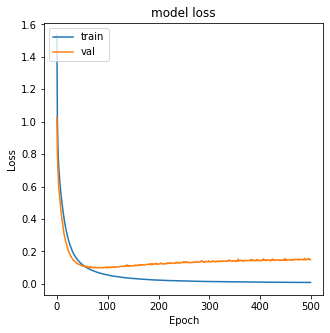

In [23]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import numpy as np
#https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
plt.figure(figsize=(5,5))
plt.plot(train_loss_ex)
plt.plot(val_loss_ex)
#plt.yticks(np.arange(0.2, 1.5, step=0.1))
#plt.xticks(np.arange(1, 15, step=1))
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:
#total_data_loss = pd.Series(epoch_ex,train_loss_ex,val_loss_ex)
total_train_loss = pd.Series(train_loss_ex)
total_val_loss = pd.Series(val_loss_ex)
total_train_loss=pd.DataFrame(total_train_loss, columns=["train loss"])
total_val_loss =pd.DataFrame(total_val_loss, columns=["val loss"])
total_data_loss=pd.concat([total_train_loss,total_val_loss], axis=1)
total_train_loss
total_data_loss.to_csv(r'total_loss.csv',  index=None)

# Save model

In [24]:
#https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [25]:
save_name="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pth"
torch.save(transformer,save_name)

In [26]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

save file .pt

In [ ]:
save_name_pt="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pt"
torch.save(transformer,save_name_pt)

In [48]:
files.download("/content/my_checkpoint_300.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load model

In [ ]:
model = torch.load('/content/gdrive/MyDrive/Colab Notebooks/code transformer/model/model/model_tranformer_epochs_500.pth')

#Translation

In [27]:
import pandas as pd
import numpy as np

In [28]:
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)
df

,input,target
0,<RX_1> O = C 1 C C [ C @ H ] ( C N 2 C C N ( C...,C S ( = O ) ( = O ) O C [ C @ H ] 1 C C C ( = ...
1,<RX_6> N c 1 n c 2 [ n H ] c ( C C C c 3 c s c...,C O C ( = O ) c 1 c c ( C C C c 2 c c 3 c ( = ...
2,<RX_9> C C 1 ( C ) O B ( c 2 c c c c ( N c 3 n...,C C 1 ( C ) O B ( B 2 O C ( C ) ( C ) C ( C ) ...
3,<RX_6> C C ( C ) ( C ) O C ( = O ) N C C ( = O...,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) C C ...
4,<RX_1> F c 1 c c 2 c ( N C 3 C C C C C C 3 ) n...,F c 1 c c 2 c ( C l ) n c n c 2 c n 1 . N C 1 ...
...,...,...
50032,<RX_1> C C ( C ) ( C ) O C ( = O ) N 1 C C c 2...,C C ( C ) ( C ) O C ( = O ) N 1 C C c 2 c c c ...
50033,<RX_2> C C ( = O ) O C C N C ( = O ) O C ( C )...,C C ( = O ) C l . C C ( C ) ( C ) O C ( = O ) ...
50034,<RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1...,C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c ...
50035,<RX_1> C C ( C ) ( C ) O C 1 C [ C @ @ H ] 2 C...,C C ( C ) ( C ) O . O = C C 1 = C [ C @ H ] 2 ...


In [33]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [34]:
for i in range(50000,50010):
  translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  print("    ")

Product: <RX_9> O = C ( O ) C ( = O ) O

Reaction Real: C c 1 c c c ( B r ) c 2 c 1 C ( C ( C ) C ) N ( C ( = O ) C N C C 1 ( O ) C C 
C C C 1 ) C C 2

prediction: N # C c 1 n c ( - c 2 c c c c c 2 ) c

Product: <RX_3> C C O C ( = O ) C = C C c 1 c c c ( B r ) c c 1

Reaction Real: C C O C ( = O ) C = P ( c 1 c c c c c 1 ) ( c 1 c c c c c 1 ) c 1 c c c c c 1 
. O = C C c 1 c c c ( B r ) c c 1

prediction: B r c 1 c c c ( C [ P + ] ( c 2 c c c c c 2 ) ( c 2 c c c c c

Product: <RX_6> C c 1 c c ( C 2 = N O C ( c 3 c c ( C l ) c c ( C l ) c 3 ) ( C ( F ) ( F ) F
) C 2 = N O ) c c c 1 C ( = O ) O

Reaction Real: C c 1 c c ( C 2 = N O C ( c 3 c c ( C l ) c c ( C l ) c 3 ) ( C ( F ) ( F ) F 
) C 2 = N O ) c c c 1 C ( = O ) O C ( C ) ( C ) C

prediction: C O C ( = O ) c 1 c c c ( C 2 = N O C ( c 3 c c ( C l ) c c ( C l ) c 3 ) ( C ( F
) ( F ) F ) C 2 = N O ) c c 1 C

Product: <RX_6> N # C c 1 n c c ( B r ) c ( N ( N ) C 2 C C O C C 2 ) n 1

Reaction Real: C C ( C ) ( C ) O C ( = O ) N N ( c 1 n c ( C # N ) n c c 1 B r ) C 1 C C O C 
C 1

prediction: C C ( C ) ( C ) O C ( = O ) N N ( c 1 n c ( C # N ) n c c 1 B r ) C 1 C

Product: <RX_2> O = C 1 C C C ( N 2 C c 3 c c ( C N C ( = O ) N 4 C C O C C 4 ) c c c 3 C 2 =
O ) C ( = O ) N 1

Reaction Real: N C c 1 c c c 2 c ( c 1 ) C N ( C 1 C C C ( = O ) N C 1 = O ) C 2 = O . O = C 
( C l ) N 1 C C O C C 1

prediction: N C c 1 c c c 2 c ( c 1 ) C N ( C 1 C C C ( = O ) N C 1 = O ) C 2 = O . O = C ( C
l ) N 1 C C O C C 1

Product: <RX_7> C c 1 c c c ( N ) c c 1 C ( = O ) N S ( C ) ( = O ) = O

Reaction Real: C c 1 c c c ( [ N + ] ( = O ) [ O - ] ) c c 1 C ( = O ) N S ( C ) ( = O ) = O

prediction: C c 1 c c c ( [ N + ] ( = O ) [ O - ] ) c c 1 C ( = O ) N S ( C ) ( =

Product: <RX_6> O = C ( O ) C c 1 c c c 2 s c ( = O ) [ n H ] c 2 c 1

Reaction Real: C C O C ( = O ) C c 1 c c c 2 s c ( = O ) [ n H ] c 2 c 1

prediction: C C O C ( = O ) C c 1 c c c 2 s c ( = O ) [ n H ] c 2 c 1

Product: <RX_9> N C ( = O ) C 1 C C N ( C C C O c 2 c c c ( - n 3 n c 4 c c c c c 4 c 3 C l )
c c 2 ) C C 1

Reaction Real: N . O = C ( O ) C 1 C C N ( C C C O c 2 c c c ( - n 3 n c 4 c c c c c 4 c 3 C 
l ) c c 2 ) C C 1

prediction: C O C ( = O ) C 1 C C N ( C C C O c 2 c c c ( - n 3 n c 4 c c c c c 4 c 3 C l ) c
c 2 ) C C 1 . N

Product: <RX_2> C C ( C ) ( C ) c 1 c c c ( C N ( C C c 2 c c ( F ) c c ( C ( F ) ( F ) F ) c
2 ) C ( = O ) c 2 c c ( C ( F ) ( F ) F ) c c ( C l ) c 2 F ) c c 1

Reaction Real: C C ( C ) ( C ) c 1 c c c ( C N C C c 2 c c ( F ) c c ( C ( F ) ( F ) F ) c 2 
) c c 1 . O = C ( O ) c 1 c c ( C ( F ) ( F ) F ) c c ( C l ) c 1 F

prediction: C C ( C ) ( C ) c 1 c c c ( C N C C c 2 c c ( F ) c c ( C ( F ) ( F ) F ) c 2 ) c
c 1 . O = C ( O ) c 1 c c ( C ( F ) ( F ) F ) c c ( C l ) c 1 F

Product: <RX_1> C C O C ( = O ) c 1 c o c 2 c c ( N 3 C ( = O ) c 4 c c c c c 4 C 3 = O ) c c
c 1 2

Reaction Real: C C O C ( = O ) c 1 c o c 2 c c ( B r ) c c c 1 2 . O = C 1 N C ( = O ) c 2 c 
c c c c 2 1

prediction: C C O C ( = O ) c 1 c o c 2 c c ( N C ( = O ) c 3 c c c c c 3 C ( = O ) O C ) c c
c 1 2

In [59]:
i=50034
translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)

Product: <RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1 C = O

Reaction Real: C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1

prediction: C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1

#TEST

In [ ]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


In [ ]:
len(df_test.input)
len(df.input)

50037

In [ ]:
a=0
src_input=[]
for i in range(len(df.input)):
  translate_src=translate(model, df.input[i], src_vocab, tgt_vocab, tokenizer)
  src_input.append(translate_src)
  a=a+1
print(a)         

5004

In [ ]:
df_test_prediction = pd.Series(src_input)
df_test_prediction

0        c s ( = o ) ( = o ) o c [ c @ h ] 1 c c c ( =...
1        c o c ( = o ) c 1 c c ( c c c c 2 c c 3 c ( =...
2        c c 1 ( c ) o b ( b 2 o c ( c ) ( c ) c ( c )...
3        c c ( c ) ( c ) o c ( = o ) n c c ( = o ) c c...
4        f c 1 c c 2 c ( c l ) n c n c 2 c n 1 . n c 1...
                              ...                        
4999            c c ( c ) ( c ) o c ( = o ) n 1 c c c ( c
5000     n c 1 c c c ( n 2 c c n ( c 3 n c c c n 3 ) c...
5001     b r c c c o c 1 c c c c c 1 . c o c ( = o ) c...
5002     c n . o = c 1 n c ( = o ) c 2 c 1 c ( - c 1 c...
5003     c c ( c ) n 1 c ( b r ) c c 2 c 1 c ( c 1 c c...
Length: 5004, dtype: object

In [ ]:
df_test_prediction= pd.DataFrame(df_test_prediction, columns=["prediction"])
df_test_prediction

,prediction
0,c s ( = o ) ( = o ) o c [ c @ h ] 1 c c c ( =...
1,c o c ( = o ) c 1 c c ( c c c c 2 c c 3 c ( =...
2,c c 1 ( c ) o b ( b 2 o c ( c ) ( c ) c ( c )...
3,c c ( c ) ( c ) o c ( = o ) n c c ( = o ) c c...
4,f c 1 c c 2 c ( c l ) n c n c 2 c n 1 . n c 1...
...,...
4999,c c ( c ) ( c ) o c ( = o ) n 1 c c c ( c
5000,n c 1 c c c ( n 2 c c n ( c 3 n c c c n 3 ) c...
5001,b r c c c o c 1 c c c c c 1 . c o c ( = o ) c...
5002,c n . o = c 1 n c ( = o ) c 2 c 1 c ( - c 1 c...


In [ ]:
#save df to .txt

In [ ]:
#https://stackoverflow.com/questions/31247198/python-pandas-write-content-of-dataframe-into-text-file
df_test_prediction.to_csv(r'predictions.csv', header=None, index=None)


#beam search 

ModuleNotFoundError: ignored